**Column Details:**
- **day**: The day of the month.
- **pressure**: Atmospheric pressure in hPa.
- **maxtemp**: Maximum recorded temperature in °C.
- **temparature**: Average temperature of the day in °C.
- **mintemp**: Minimum recorded temperature in °C.
- **dewpoint**: Dew point temperature in °C.
- **humidity**: Relative humidity percentage.
- **cloud**: Cloud cover percentage.
- **rainfall**: Indicates whether rainfall occurred (yes/no).
- **sunshine**: Total sunshine duration in hours.
- **winddirection**: Wind direction in degrees.
- **windspeed**: Wind speed in km/h.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/content/Rainfall.csv")
df.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [4]:
df.shape

(366, 12)

In [5]:
df.columns

Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')

* winddirection attribute has some unnecessary space let's fix it.

In [6]:
df.rename(columns={'         winddirection': 'winddirection'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            366 non-null    int64  
 1   pressure       366 non-null    float64
 2   maxtemp        366 non-null    float64
 3   temparature    366 non-null    float64
 4   mintemp        366 non-null    float64
 5   dewpoint       366 non-null    float64
 6   humidity       366 non-null    int64  
 7   cloud          366 non-null    int64  
 8   rainfall       366 non-null    object 
 9   sunshine       366 non-null    float64
 10  winddirection  365 non-null    float64
 11  windspeed      365 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
day,366.0,15.756831,8.823592,1.0,8.000,16.00,23.000,31.0
pressure,366.0,1013.742623,6.414776,998.5,1008.500,1013.00,1018.100,1034.6
maxtemp,366.0,26.191257,5.978343,7.1,21.200,27.75,31.200,36.3
temparature,366.0,23.747268,5.632813,4.9,18.825,25.45,28.600,32.4
mintemp,366.0,21.894536,5.594153,3.1,17.125,23.70,26.575,30.0
dewpoint,366.0,19.989071,5.997021,-0.4,16.125,21.95,25.000,26.7
humidity,366.0,80.177596,10.062470,36.0,75.000,80.50,87.000,98.0
cloud,366.0,71.128415,21.798012,0.0,58.000,80.00,88.000,100.0
sunshine,366.0,4.419399,3.934398,0.0,0.500,3.50,8.200,12.1
winddirection,365.0,101.506849,81.723724,10.0,40.000,70.00,190.000,350.0


In [9]:
#Data cleaning
df.isnull().sum()

,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
rainfall,0
sunshine,0


We have 2 null values in 2 columns one each let's fill them with it's mean value.

In [10]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        val = df[col].mean()
        df[col] = df[col].fillna(val)
df.isnull().sum().sum()

0

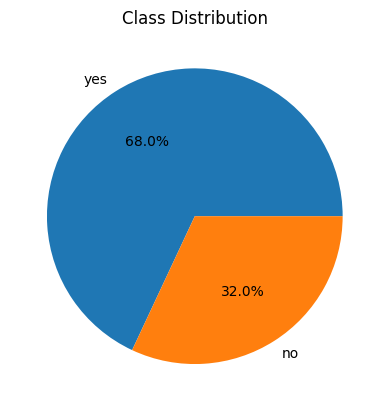

In [11]:
# EDA
plt.pie(df['rainfall'].value_counts().values,
        labels = df['rainfall'].value_counts().index,
        autopct = '%1.1f%%')
plt.title("Class Distribution")
plt.show()

We do observe that the class is imbalanced but since the data is of an entire year we should not balance it.

In [12]:
df.groupby('rainfall').mean().T

rainfall,no,yes
day,15.623932,15.819277
pressure,1014.576923,1013.350602
maxtemp,27.070940,25.777912
temparature,24.053846,23.603213
mintemp,21.957265,21.865060
dewpoint,18.766667,20.563454
humidity,73.000000,83.550201
cloud,51.256410,80.465863
sunshine,7.586325,2.931325
winddirection,103.076923,100.769104


Here we can clearly record quite few interesting obsetvations.
- maxtemp is lower during the rainfall days.
- dewpoin is more on the days when it rains
- humidity is significantly more on days of rainfall, same goes for clouds, sunshine and windspeed as well.

We can also say that the data observed in here is very similar to real life situation.

In [13]:
# We don't have any use of days column so let's remove it
df.drop('day', axis=1, inplace=True)

In [14]:
num_cols = list(df.select_dtypes(include=np.number).columns)
num_cols

['pressure ',
 'maxtemp',
 'temparature',
 'mintemp',
 'dewpoint',
 'humidity ',
 'cloud ',
 'sunshine',
 'winddirection',
 'windspeed']

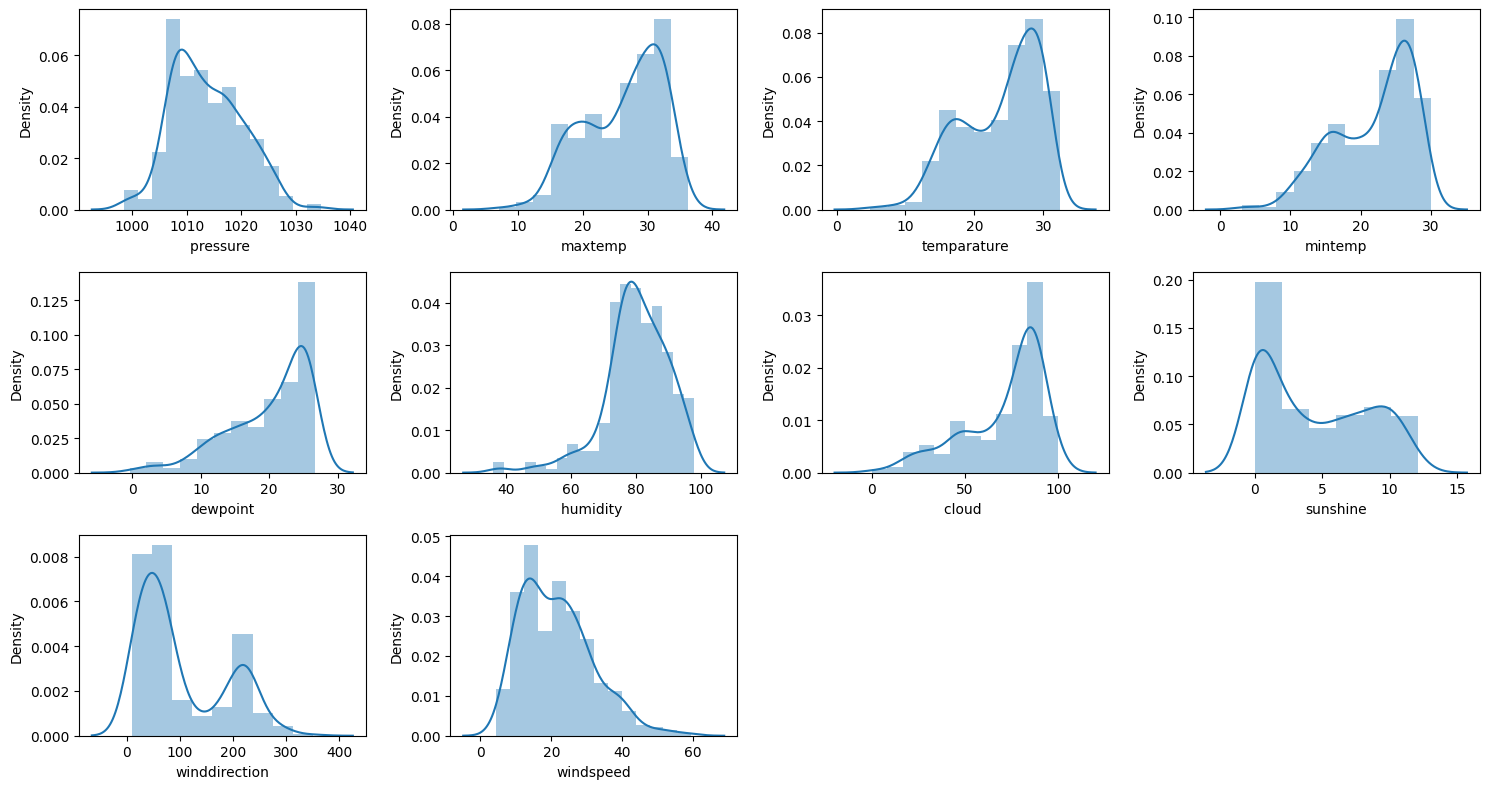

In [15]:
# Let's check the distribution of the numerical columns of the dataset
plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols):
    plt.subplot(3, 4, i+1)
    sns.distplot(df[col])
    plt.tight_layout()
plt.show()

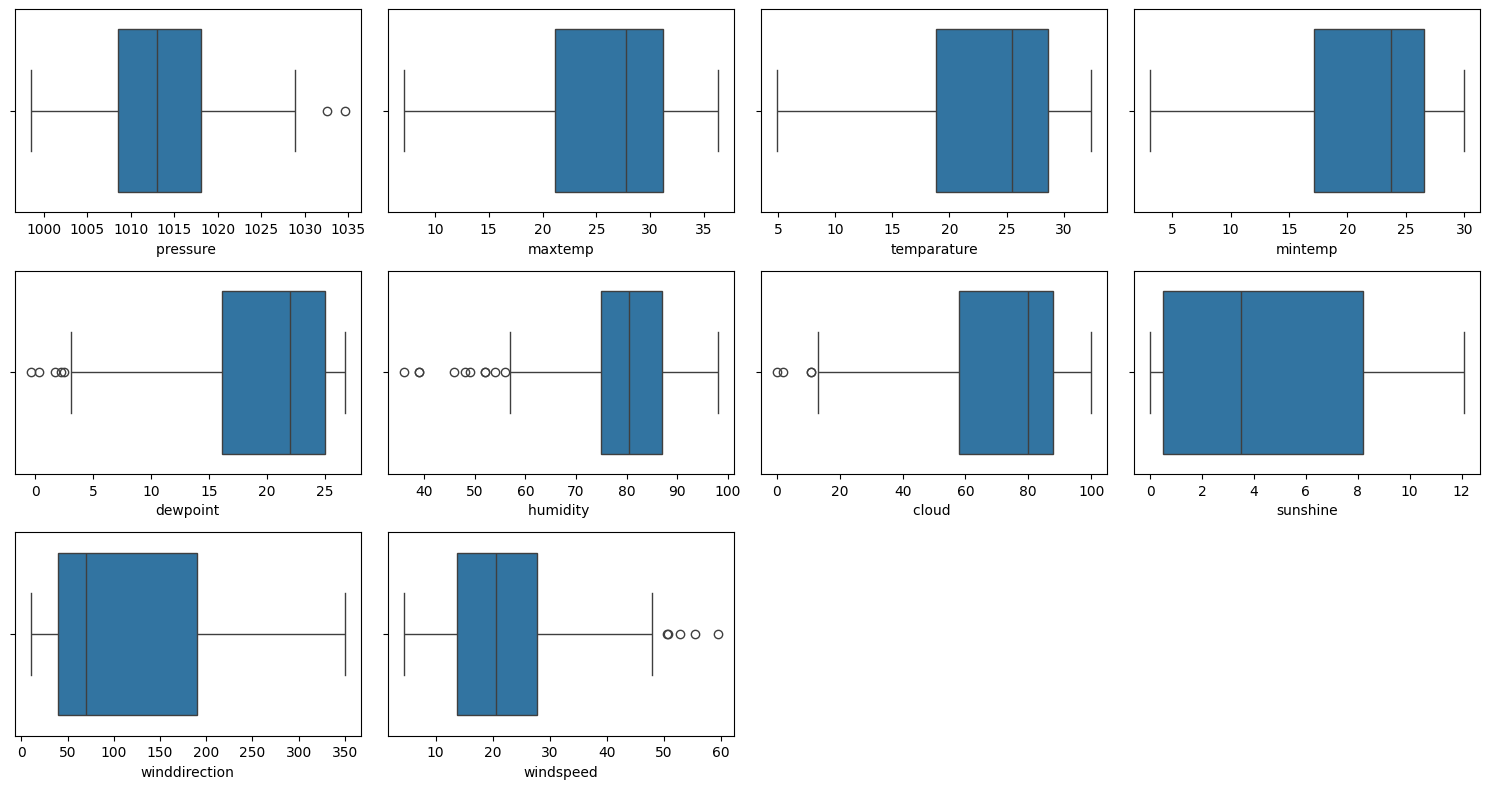

In [16]:
# Checking distribution using voxplot
plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=df[col])
    plt.tight_layout()
plt.show()

There are a few outliers in the dataset but we do not have much data so we will retain them.

In [17]:
# Let's convert object type column into numerical type.
df['rainfall']=df['rainfall'].map({'yes':1, 'no':0})

<Axes: >

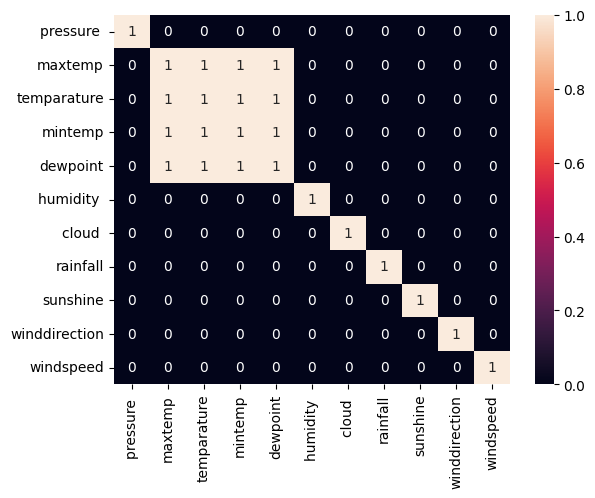

In [18]:
# Let's check correlation amont the columns
sns.heatmap(df.corr()>0.8, annot=True)

We can see few columns appears to be highly correlated so we'll be removing maxtemp and mintemp. We are aoiding removing temperature and dewpoint because they provide different atmospheric conditions.

In [19]:
df.drop(['maxtemp','mintemp'], axis=1, inplace=True)

Model Training

In [20]:
# Feature Extraction
x = df.drop(['rainfall'], axis=1)
y = df['rainfall']
x.shape, y.shape

((366, 8), (366,))

In [22]:
# Splitting the data set for training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#For imbalanced data we'll be using Random Oversampling method to fix it
ros = RandomOverSampler(sampling_strategy='minority', random_state=43)
X, Y = ros.fit_resample(x_train, y_train)

In [24]:
# Normalizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
x_test = scaler.fit_transform(x_test)

In [32]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for model in models:
    model.fit(X, Y)
    print(model.__class__.__name__)

    print("Training Accuracy: ",metrics.roc_auc_score(Y, model.predict(X)))
    print("Testing Accuracy: ",metrics.roc_auc_score(y_test, model.predict(x_test)))
    print()

LogisticRegression
Training Accuracy:  0.7613065326633166
Testing Accuracy:  0.8491666666666666

XGBClassifier
Training Accuracy:  1.0
Testing Accuracy:  0.7858333333333334

SVC
Training Accuracy:  0.7864321608040201
Testing Accuracy:  0.8583333333333333



LogisticRegression() : 
Training Accuracy :  0.869574000656549
Validation Accuracy :  0.9225

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.8675

SVC(probability=True) : 
Training Accuracy :  0.892174440039393
Validation Accuracy :  0.